#Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter

import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import string
from nltk import ngrams
from nltk.tokenize import word_tokenize

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from scipy.stats import uniform
from tqdm.notebook import tqdm
from wordcloud import WordCloud

#Baca Data

In [ ]:
df = pd.read_excel("https://github.com/Adkurrr/A-comparison-of-three-sentiment-analysis-algorithms-on-the-waste-alms-program/blob/main/Jawaban%20Kuesioner%20Sedekah%20Sampah.xlsx?raw=true")
df.head()

,Nama,Divisi,Tahun Mulai Partisipasi,Alasan Sedekah Sampah,Frequensi,Dampak yang Dirasakan,Respon Lingkungan,Hambatan,Tingkat Kepuasan,Kritik Saran
0,Nina maryani,CSR,2023,Saya ingin berkontribusi sama perusahaan walau...,Kadang-kadang,Sampah di rumah terkelola dengan baik,Baik,Di lingkungan rumah ada bank sampah jadi sampa...,Sangat Puas,Harusnya sampah yang di utamakan di sedekahkan...
1,Sania Rahmah Dinata,QARD,2021,Berpartisipasi dalam program CSR dalam sedekah...,1x dalam seminggu,Mengurangi sampah dirumah.,Baik,Tidak ada.,Sangat Puas,Pertahankan program sedekah sampah yang sangat...
2,Angga Mey Sendra,Plant 14,2024,Agar dapat dimanfaatkan oleh perusahaan tempat...,1x dalam seminggu,Mengurangi limbah sampah. Istri menjadi semang...,Baik,Tidak ada,Sangat Puas,Lebih banyak reward seperti terbanyak dalam se...
3,VIDYA,FAD,2023,Untuk Indocement,Kadang-kadang,Ada teman yang mau juga ikut partisipasi sedek...,Baik,Tidak ada,Puas,NaN
4,Firdausa Abidin,Plant 7-8,2023,Kontribusi karyawan untuk berperan aktif terha...,1x dalam seminggu,Berpartisipasi mengurangi sampah di lingkungan...,Baik,Perlu waktu memilah sampah & tempat penyimpana...,Sangat Puas,Mohon dapat di pilah kembali sampah yang di te...


#Praproses Data

In [ ]:
#cek tipe data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Nama                     30 non-null     object
 1   Divisi                   30 non-null     object
 2   Tahun Mulai Partisipasi  30 non-null     int64 
 3   Alasan Sedekah Sampah    30 non-null     object
 4   Frequensi                30 non-null     object
 5   Dampak yang Dirasakan    30 non-null     object
 6   Respon Lingkungan        30 non-null     object
 7   Hambatan                 30 non-null     object
 8   Tingkat Kepuasan         30 non-null     object
 9   Kritik Saran             21 non-null     object
dtypes: int64(1), object(9)
memory usage: 2.5+ KB


In [ ]:
#cek missing value
df.isnull().sum()

,0
Nama,0
Divisi,0
Tahun Mulai Partisipasi,0
Alasan Sedekah Sampah,0
Frequensi,0
Dampak yang Dirasakan,0
Respon Lingkungan,0
Hambatan,0
Tingkat Kepuasan,0
Kritik Saran,9


isi missing value pada kolom kritik saran dengan NaN

In [ ]:
df.fillna('', inplace=True)

In [ ]:
#cek data duplicate
df.duplicated().sum()

0

#lowercase, menghapus stopwords, dan menghapus tanda baca

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean(review):
    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in stopwords.words('indonesian')])

    return review

In [ ]:
df['Alasan Sedekah Sampah'] = df['Alasan Sedekah Sampah'].apply(clean)
df['Dampak yang Dirasakan'] = df['Dampak yang Dirasakan'].apply(clean)
df['Hambatan'] = df['Hambatan'].apply(clean)
df['Kritik Saran'] = df['Kritik Saran'].apply(clean)

In [ ]:
df.head(5)

,Nama,Divisi,Tahun Mulai Partisipasi,Alasan Sedekah Sampah,Frequensi,Dampak yang Dirasakan,Respon Lingkungan,Hambatan,Tingkat Kepuasan,Kritik Saran
0,Nina maryani,CSR,2023,berkontribusi perusahaan sekala,Kadang-kadang,sampah rumah terkelola,Baik,lingkungan rumah bank sampah sampah sedekahkan,Sangat Puas,sampah utamakan sedekahkan rumah kantor
1,Sania Rahmah Dinata,QARD,2021,berpartisipasi program csr sedekah sampah memb...,1x dalam seminggu,mengurangi sampah dirumah,Baik,,Sangat Puas,pertahankan program sedekah sampah bagus
2,Angga Mey Sendra,Plant 14,2024,dimanfaatkan perusahaan mencari nafkah,1x dalam seminggu,mengurangi limbah sampah istri semangat mengum...,Baik,,Sangat Puas,reward sebulan
3,VIDYA,FAD,2023,indocement,Kadang-kadang,teman partisipasi sedekah sampah menitipkannya,Baik,,Puas,
4,Firdausa Abidin,Plant 7-8,2023,kontribusi karyawan berperan aktif pengolahan ...,1x dalam seminggu,berpartisipasi mengurangi sampah lingkungan pe...,Baik,memilah sampah penyimpanan rapi,Sangat Puas,mohon pilah sampah terima permasalahan metal m...


#Exploratory Data Analysis

###Visualisasi data

<ipython-input-11-c6b4e1ce47c5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Divisi', data=df, palette='Set1', hue=None)


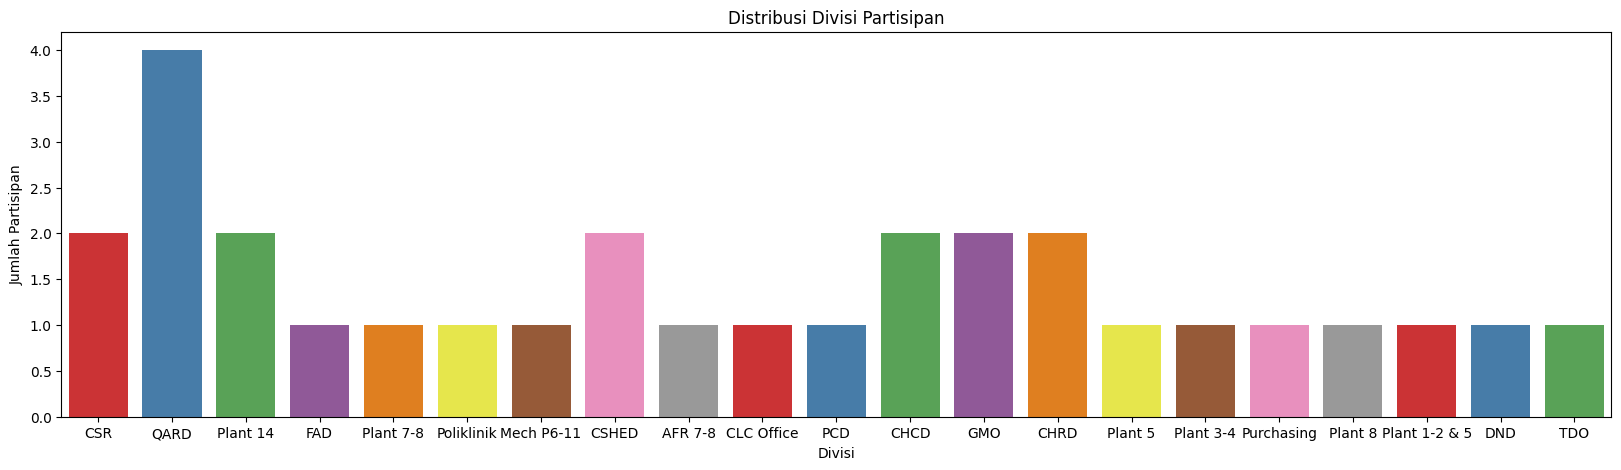

In [ ]:
# Plot barchart untuk kolom Divisi
plt.figure(figsize=(20, 5))
sns.countplot(x='Divisi', data=df, palette='Set1', hue=None)
plt.title('Distribusi Divisi Partisipan')
plt.xlabel('Divisi')
plt.ylabel('Jumlah Partisipan')
plt.show()

<ipython-input-12-fb2e6f883fde>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Respon Lingkungan', data=df, palette='Set1', hue=None)


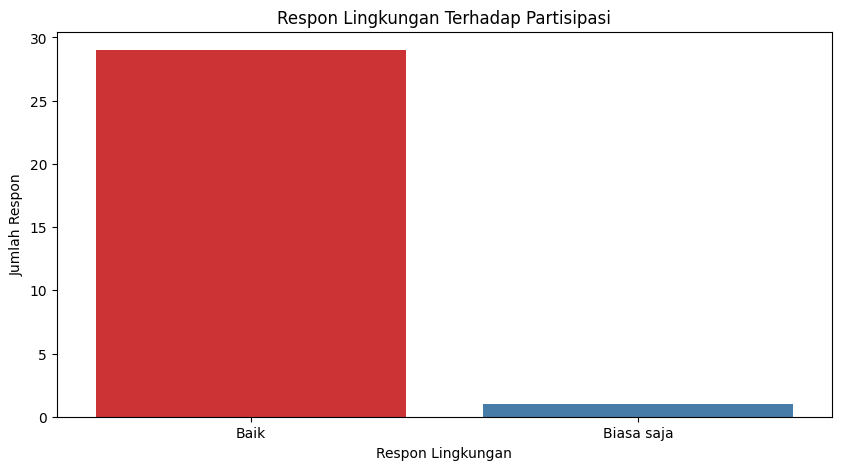

In [ ]:
# Plot barchart untuk kolom Respon Lingkungan
plt.figure(figsize=(10, 5))
sns.countplot(x='Respon Lingkungan', data=df, palette='Set1', hue=None)
plt.title('Respon Lingkungan Terhadap Partisipasi')
plt.xlabel('Respon Lingkungan')
plt.ylabel('Jumlah Respon')
plt.show()

<ipython-input-13-3468963d5fd7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Tingkat Kepuasan', data=df, palette='Set1', hue=None)


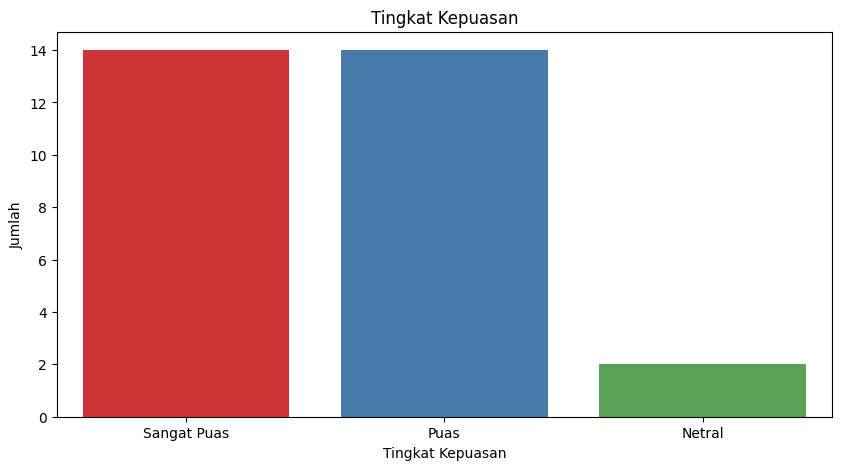

In [ ]:
# Plot barchart untuk kolom Tingkat Kepuasan
plt.figure(figsize=(10, 5))
sns.countplot(x='Tingkat Kepuasan', data=df, palette='Set1', hue=None)
plt.title('Tingkat Kepuasan')
plt.xlabel('Tingkat Kepuasan')
plt.ylabel('Jumlah')
plt.show()

<ipython-input-14-136ee20a1a85>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Frequensi', data=df, palette='Set1', hue=None)


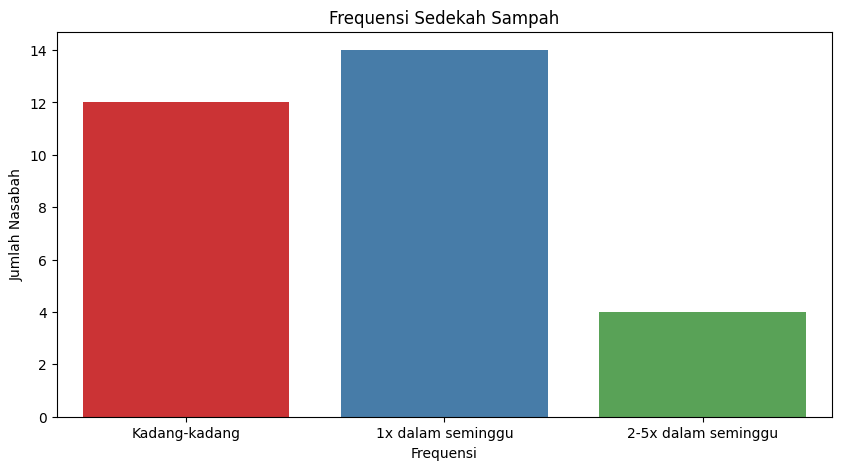

In [ ]:
# Plot barchart untuk kolom Frequensi
plt.figure(figsize=(10, 5))
sns.countplot(x='Frequensi', data=df, palette='Set1', hue=None)
plt.title('Frequensi Sedekah Sampah')
plt.xlabel('Frequensi')
plt.ylabel('Jumlah Nasabah')
plt.show()

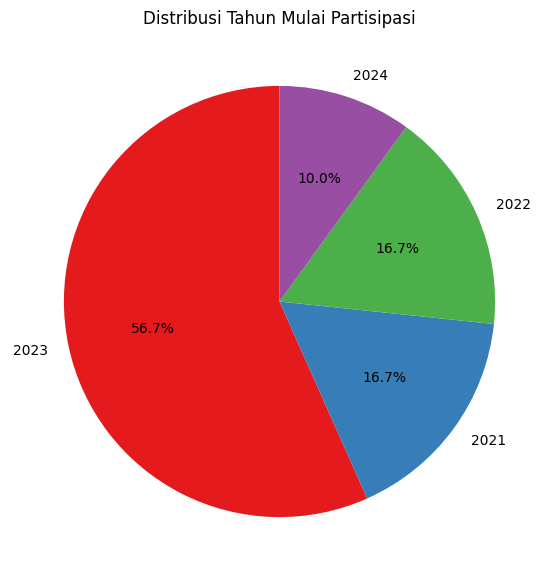

In [ ]:
# Pie chart untuk kolom Tahun Partisipasi
plt.figure(figsize=(7, 7))
df['Tahun Mulai Partisipasi'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set1'), startangle=90)
plt.title('Distribusi Tahun Mulai Partisipasi')
plt.ylabel('')  # Menghilangkan label y
plt.show()

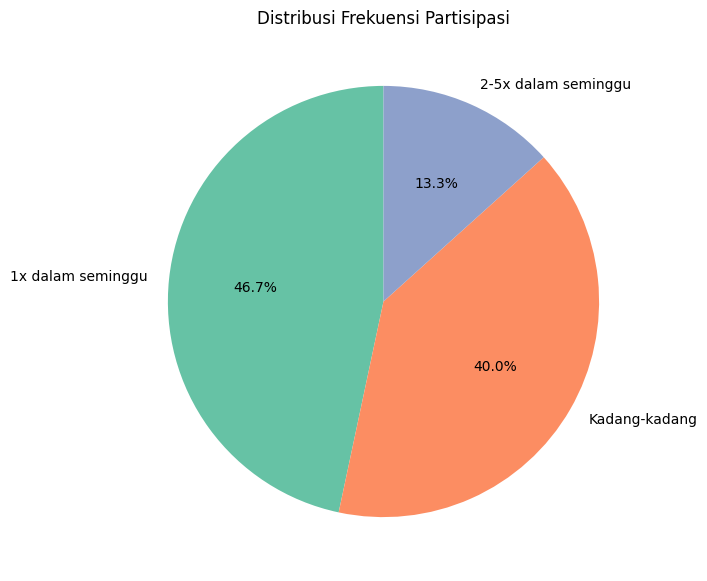

In [ ]:
# Pie chart untuk kolom Frekuensi Partisipasi
plt.figure(figsize=(7, 7))
df['Frequensi'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=90)
plt.title('Distribusi Frekuensi Partisipasi')
plt.ylabel('')
plt.show()

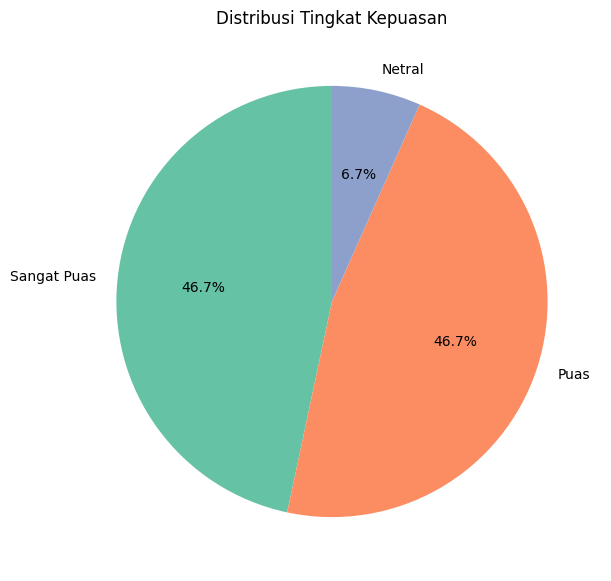

In [ ]:
# Pie chart untuk kolom Tingkat Kepuasan
plt.figure(figsize=(7, 7))
df['Tingkat Kepuasan'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=90)
plt.title('Distribusi Tingkat Kepuasan')
plt.ylabel('')
plt.show()

#Wordcloud

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def generate_bigrams(text):
    words = word_tokenize(text.lower())
    bigrams = list(ngrams(words, 2))
    return bigrams

def generate_trigrams(text):
    words = word_tokenize(text.lower())
    trigrams = list(ngrams(words, 3))
    return trigrams

###Wordcloud untuk alasan sedekah sampah

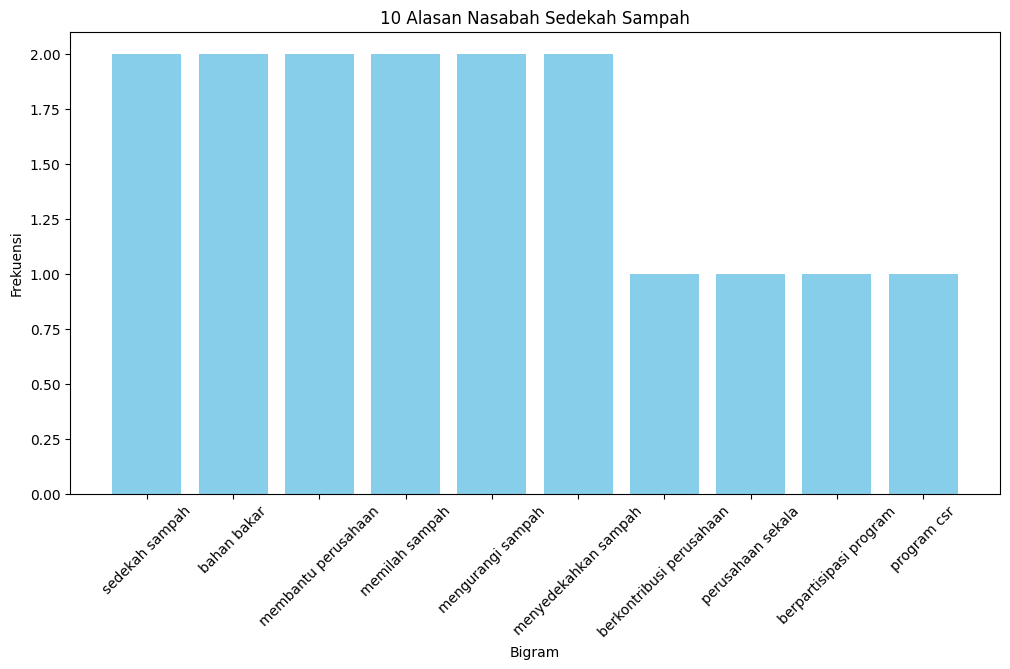

In [ ]:
df['Bigrams_alasan'] = df['Alasan Sedekah Sampah'].apply(generate_bigrams)

all_bigrams = []
for index, row in df.iterrows():
    all_bigrams += row['Bigrams_alasan']
bigram_counts = Counter(all_bigrams)

most_common_bigrams = bigram_counts.most_common(10)
most_common_bigrams

# Menampilkan hasil dengan bar chart
bigrams, counts = zip(*most_common_bigrams)
bigrams = [' '.join(bigram) for bigram in bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigrams, counts, color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('10 Alasan Nasabah Sedekah Sampah')
plt.xticks(rotation=45)
plt.show()

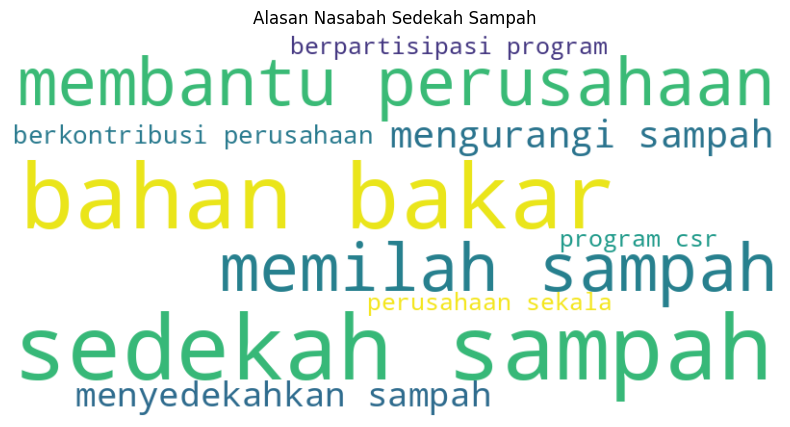

In [ ]:
# Convert list of bigrams to dictionary for wordcloud
word_freq_dict = { ' '.join(bigram): freq for bigram, freq in most_common_bigrams }

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Alasan Nasabah Sedekah Sampah')
plt.axis('off')
plt.show()

###Dampak yang Dirasakan

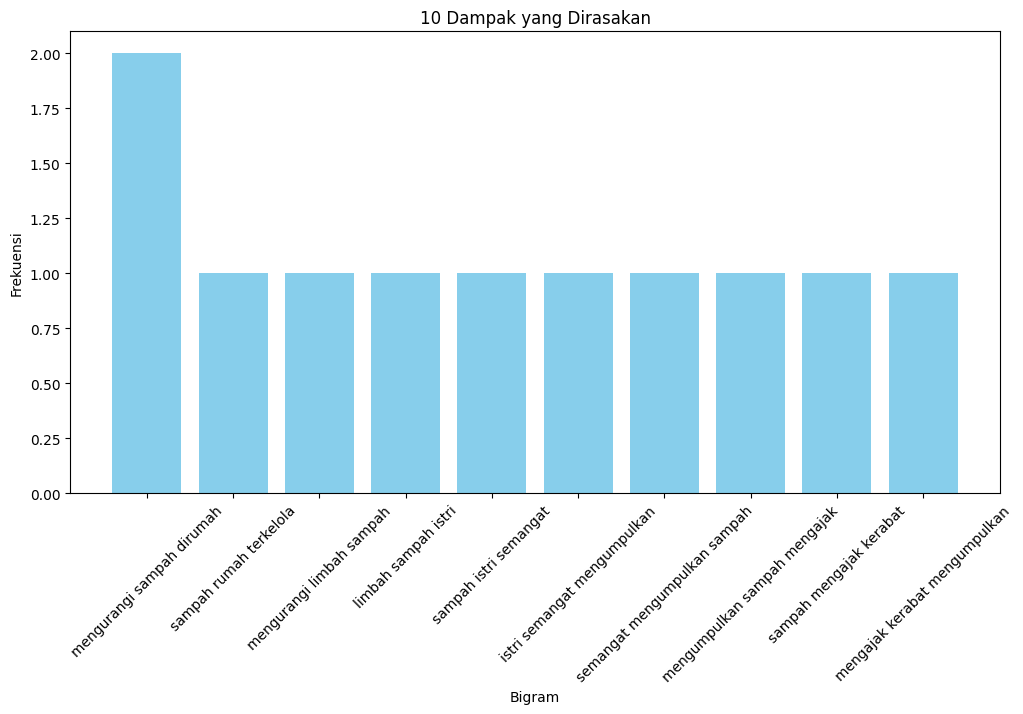

In [ ]:
df['Bigrams_alasan'] = df['Dampak yang Dirasakan'].apply(generate_trigrams)

all_bigrams = []
for index, row in df.iterrows():
    all_bigrams += row['Bigrams_alasan']
bigram_counts = Counter(all_bigrams)

most_common_bigrams = bigram_counts.most_common(10)
most_common_bigrams

# Menampilkan hasil dengan bar chart
bigrams, counts = zip(*most_common_bigrams)
bigrams = [' '.join(bigram) for bigram in bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigrams, counts, color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('10 Dampak yang Dirasakan')
plt.xticks(rotation=45)
plt.show()

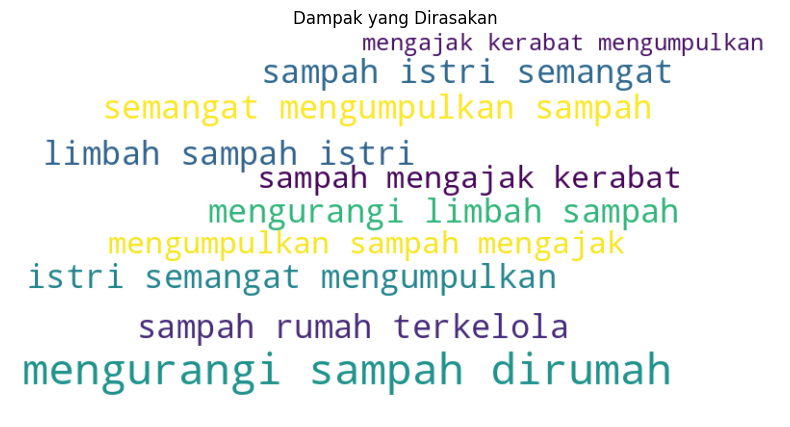

In [ ]:
# Convert list of bigrams to dictionary for wordcloud
word_freq_dict = { ' '.join(bigram): freq for bigram, freq in most_common_bigrams }

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Dampak yang Dirasakan')
plt.axis('off')
plt.show()

###wordcloud hambatan

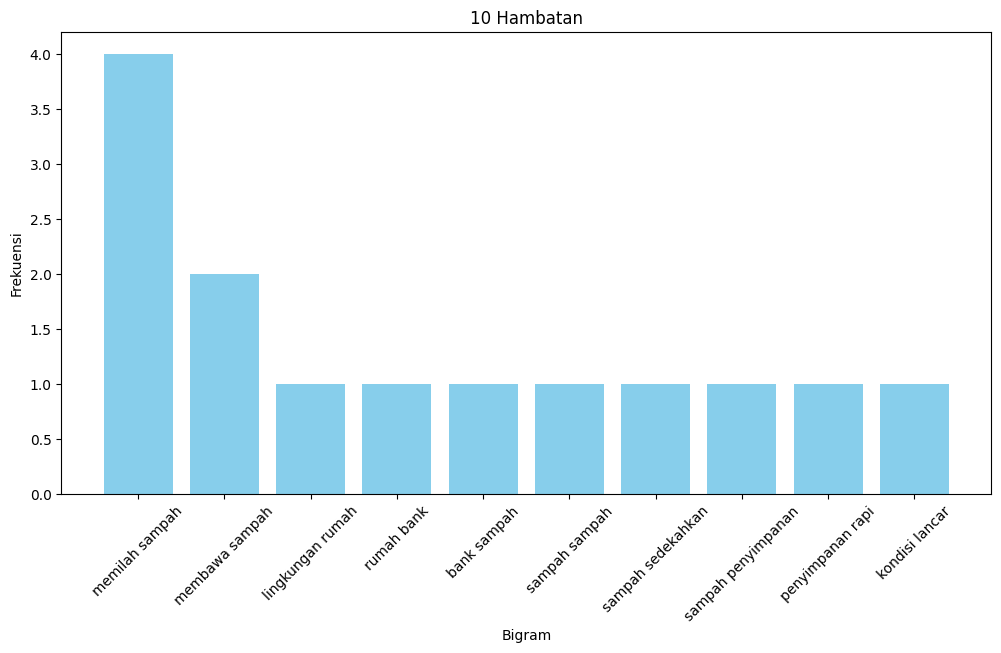

In [ ]:
df['Bigrams_hambatan'] = df['Hambatan'].apply(generate_bigrams)

all_bigrams = []
for index, row in df.iterrows():
    all_bigrams += row['Bigrams_hambatan']
bigram_counts = Counter(all_bigrams)

most_common_bigrams = bigram_counts.most_common(10)
most_common_bigrams

# Menampilkan hasil dengan bar chart
bigrams, counts = zip(*most_common_bigrams)
bigrams = [' '.join(bigram) for bigram in bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigrams, counts, color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('10 Hambatan')
plt.xticks(rotation=45)
plt.show()

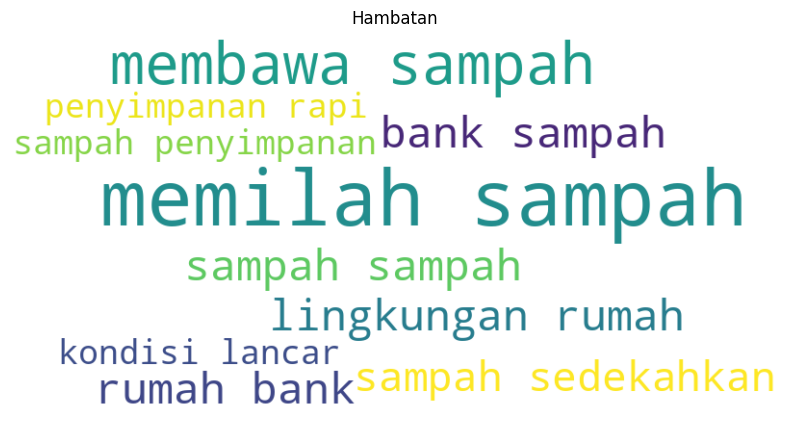

In [ ]:
# Convert list of bigrams to dictionary for wordcloud
word_freq_dict = { ' '.join(bigram): freq for bigram, freq in most_common_bigrams }

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hambatan')
plt.axis('off')
plt.show()

###wordcloud kritik saran

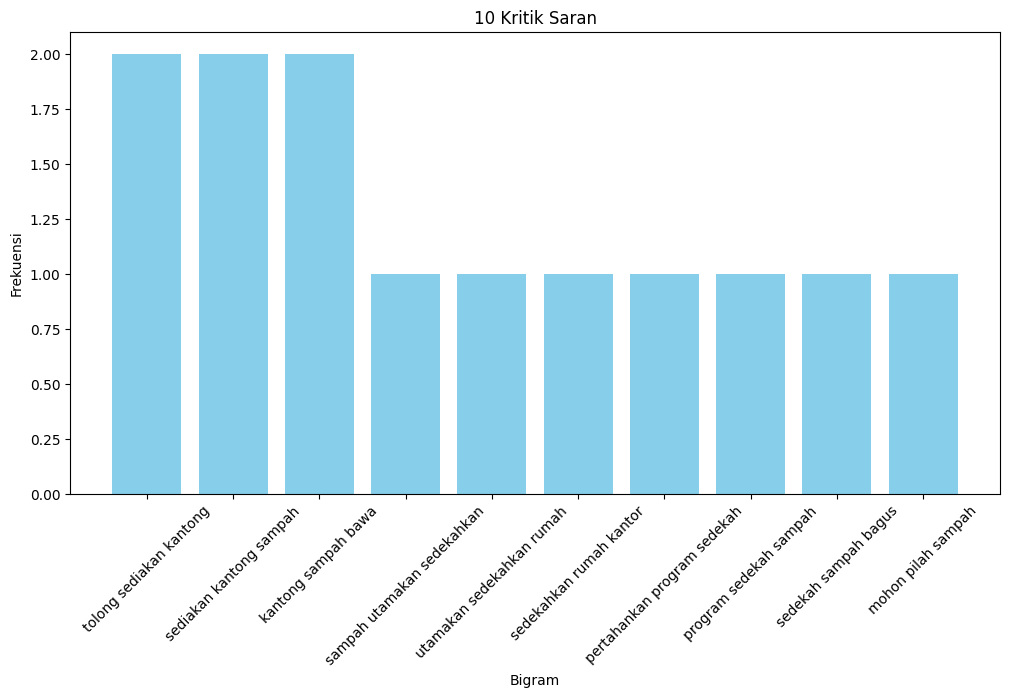

In [ ]:
df['Bigrams_saran'] = df['Kritik Saran'].apply(generate_trigrams)

all_bigrams = []
for index, row in df.iterrows():
    all_bigrams += row['Bigrams_saran']
bigram_counts = Counter(all_bigrams)

most_common_bigrams = bigram_counts.most_common(10)
most_common_bigrams

# Menampilkan hasil dengan bar chart
bigrams, counts = zip(*most_common_bigrams)
bigrams = [' '.join(bigram) for bigram in bigrams]

plt.figure(figsize=(12, 6))
plt.bar(bigrams, counts, color='skyblue')
plt.xlabel('Bigram')
plt.ylabel('Frekuensi')
plt.title('10 Kritik Saran')
plt.xticks(rotation=45)
plt.show()

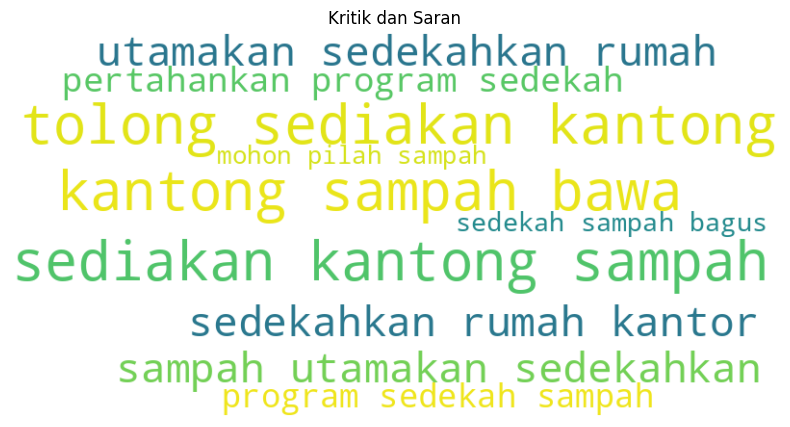

In [ ]:
# Convert list of bigrams to dictionary for wordcloud
word_freq_dict = { ' '.join(bigram): freq for bigram, freq in most_common_bigrams }

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Visualisasi word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Kritik dan Saran')
plt.axis('off')
plt.show()

#Build Model

In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Initialize stemmer and stopwords
stop_words = set(stopwords.words('english'))  # For English; adapt if needed
stemmer = PorterStemmer()
sia = SentimentIntensityAnalyzer()

# Fungsi untuk melakukan stemming
def stem_text(text):
    words = word_tokenize(text.lower())  # Tokenisasi kata dan ubah menjadi lowercase
    stemmed_words = [stemmer.stem(word) for word in words if word.isalnum()]  # Lakukan stemming pada setiap kata
    return ' '.join(stemmed_words)  # Gabungkan kata-kata yang sudah di-stem menjadi teks

# Loop untuk menganalisis sentimen
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    # Gabungkan teks dari kolom-kolom yang dipilih
    combined_text = ' '.join([
        row['Alasan Sedekah Sampah'],
        row['Dampak yang Dirasakan'],
        row['Respon Lingkungan'],
        row['Hambatan'],
        row['Tingkat Kepuasan'],
        row['Kritik Saran']]
        )

    # Lakukan stemming pada teks gabungan
    stemmed_text = stem_text(combined_text)

    # Hitung sentimen menggunakan VADER
    sentiment_scores = sia.polarity_scores(stemmed_text)

    # Simpan hasil ke dictionary
    res[i] = sentiment_scores

# Membuat DataFrame baru dari hasil analisis sentimen
sentiment_df = pd.DataFrame(res).T

# Membuat fungsi untuk mengklasifikasikan sentimen
def classify_sentiment(score):
    if score > 0.0:
        return 'negative'
    else:
        return 'positif'

# Mengubah skor sentimen menjadi kategori
sentiment_df['sentiment'] = sentiment_df['compound'].apply(classify_sentiment)

# Gabungkan DataFrame sentimen dengan DataFrame awal berdasarkan indeks
df = df.join(sentiment_df[['sentiment']])

  0%|          | 0/30 [00:00<?, ?it/s]

###one hot encoding

In [ ]:
# Membuat mapping untuk encoding
sentimen_mapping = {"negative": -1, "positive": 1}

# Melakukan encoding pada kolom "sentimen"
df["sentimen_encoded"] = df["sentiment"].map(sentimen_mapping)

#Train Test Split

In [ ]:
# Gabungkan kolom fitur teks menjadi satu kolom
df['features'] = df[['Alasan Sedekah Sampah', 'Dampak yang Dirasakan',
                 'Respon Lingkungan', 'Hambatan']].apply(lambda x: ' '.join(x), axis=1)

X = df['features']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Model SVM
svm_model = make_pipeline(TfidfVectorizer(), SVC(kernel='linear', probability=True))
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, svm_pred)
print("Akurasi model SVM:", accuracy)

Akurasi model SVM: 0.8888888888888888


In [ ]:
# Model Logistic Regression
log_reg_model = make_pipeline(TfidfVectorizer(), LogisticRegression())
log_reg_model.fit(X_train, y_train)
log_reg_pred = log_reg_model.predict(X_test)

log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print("Akurasi model Logistic Regression:", log_reg_accuracy)

Akurasi model Logistic Regression: 0.8888888888888888


In [ ]:
# Model Naive Bayes
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_pred)
print("Akurasi model NB:", nb_accuracy)

Akurasi model NB: 0.8888888888888888


#Kesimpulan

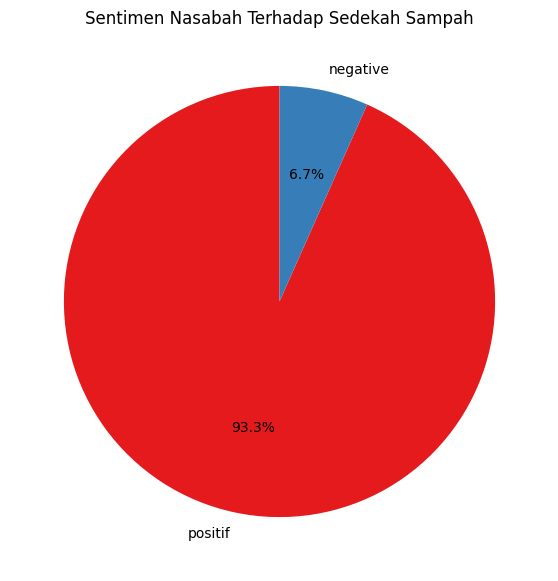

In [ ]:
# Pie chart untuk kolom Tahun Partisipasi
plt.figure(figsize=(7, 7))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set1'), startangle=90)
plt.title('Sentimen Nasabah Terhadap Sedekah Sampah')
plt.ylabel('')
plt.show()

*   Dari hasil analisis sentimen terhadap program Sedekah Sampah, didapatkan bahwa mayoritas responden (93.3%) memberikan sentimen positif, menunjukkan bahwa sebagian besar nasabah memiliki pandangan yang baik terhadap program ini. Hanya 6.7% yang memberikan sentimen negatif, yang menunjukkan bahwa kritik atau ketidakpuasan dari para nasabah relatif rendah.
*   Jika dilihat berdasarkan model machine learning yang dibuat yaitu model SVM, Naive Bayes dan Logistic Regression didapatkan rata-rata akurasi model sebesar 88%, artinya model menunjukkan performa yang baik dengan rata-rata akurasi cukup tinggi. Namun, hasil yang diperoleh belum tentu sepenuhnya merepresentasikan kondisi sebenarnya di lapangan, mengingat keterbatasan data yang digunakan dalam analisis ini. Oleh karena itu, evaluasi lebih lanjut diperlukan agar program Sedekah Sampah dapat terus berkembang secara konsisten dan, jika memungkinkan, mencapai hasil yang lebih optimal di masa mendatang.

